Notes:  
top left is 0,0

In [1]:
import cv2
from pyzbar import pyzbar

In [2]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import rcParams
from glob import glob
import string
from random import choice, shuffle, sample
import pandas as pd
import qrcode

In [3]:
rcParams['figure.dpi'] = 90
rcParams['figure.figsize'] = [10.24, 9.6]

In [46]:
class Frame():
    def __init__(self, left, right, top, bottom, font_size = None, font_path = None):
        height = bottom-top
        width = right-left
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        self.width = width
        self.height = height
        self.top_left = (left, top)
        self.bottom_right = (right,bottom)
        self.size = (width, height)
        self.font_size = font_size
        self.font_path = font_path
        self.center = (int((left+right)/2),int((top+bottom)/2))

        
class ScreenGenerator():
    def __init__(self,
        n_frames_per_screen = 10,
        font_size_range = (40,120),
        number_range = (0,200),
        include_number_noise = True,
        number_noise_font_range = (3,6),
        add_qr_corners = True,
        data_path = '/data',
        screen_size = (1024,1024),
        path_to_fonts = 'vitmoocr/fonts/',
    ):
        self.n_frames_per_screen = n_frames_per_screen
        self.font_size_range = font_size_range
        self.number_range = number_range
        self.include_number_noise = include_number_noise
        self.number_noise_font_range = number_noise_font_range
        self.add_qr_corners = add_qr_corners
        self.data_path = data_path
        self.screen_size = screen_size
        self.frames = []
        self.numbers = []
        self.font_paths = \
            glob(path_to_fonts+'/*.ttf')+\
            glob(path_to_fonts+'/*.otf')+\
            glob(path_to_fonts+'/*/*/*.ttf')+\
            glob(path_to_fonts+'/*/*/*.otf')
        self.qr_size = 2*21+2*2*4
        self.qr_size_large = 100
        self.add_qr = True
        self.center_frame = None
        self.frame_rate = 1
        
    
    def get_text_size(self,font_size,font_path='vitmoocr/fonts/DejaVuSans-Bold.ttf'):
        font = ImageFont.truetype(font_path,font_size)
        img = Image.new('RGB', (300, 300))
        draw_txt = ImageDraw.Draw(img)
        width, height = draw_txt.textsize('250', font=font)
        return width, height
    
    def compose_screen(self):
        screen_w, screen_h = self.screen_size
        qr_size = self.qr_size_large
        self.frames = []
        self.center_frame = Frame(
                left=int(screen_w/2-qr_size/2),
                right=int(screen_w/2+qr_size/2),
                top=int(screen_h/2-qr_size/2),
                bottom=int(screen_h/2+qr_size/2),
            )
        
        n_frames_per_screen = self.n_frames_per_screen
        n_failiors = 0

        while (len(self.frames)<n_frames_per_screen) & (n_failiors<n_frames_per_screen):
            overlaps = False
            
            np.random.shuffle(self.font_paths)
            font_path = self.font_paths[0]
            font_size = np.random.randint(self.font_size_range[0],self.font_size_range[1])
            # Randomly choose a top left corner
            text_width, text_height = self.get_text_size(font_size, font_path)
            top_candidate = np.random.randint(0,screen_h-text_height)
            left_candidate = np.random.randint(0,screen_w-text_width)
            # check if the candidate overlaps with any existing frames
            for frame in self.frames+[self.center_frame]:
                overlap_vert = top_candidate in range(frame.top-text_height, frame.bottom)
                overlap_hors = left_candidate in range(frame.left-text_width, frame.right)
                
                if overlap_vert and overlap_hors:
                    n_failiors = n_failiors+1
                    overlaps = True
                    break
            if not overlaps:
                self.frames.append(Frame(
                    left=left_candidate, 
                    right=left_candidate+text_width,
                    top=top_candidate,
                    bottom=top_candidate+text_height,
                    font_size=font_size,
                    font_path = font_path
                ))
                
    def generate_random_nan(self):
        chars=string.printable[10:-16]
        size = np.random.randint(1,4)
        return ''.join(choice(chars) for _ in range(size))
    
    def generate_image_id_set(self):
        chars=string.printable[10:-16]
        size = 6
        image_id = ''.join(choice(chars) for _ in range(size))
        return 'nums_'+image_id, 'labs_'+image_id
                
    def generate_numbers(self, n=1000):
        n = n/65
        numbers = []
        # X XX XXX nan
        weights = [3,4,5,3]
        # X
        for i in range(int( n*weights[0]/np.sum(weights) )):
            numbers = numbers+list(range(0,10))
        # XX
        for i in range(int( n*weights[1]/np.sum(weights) )):
            numbers = numbers+list(range(10,100))
        # XXX
        for i in range(int( n*weights[2]/np.sum(weights) )):
            numbers = numbers+list(range(100,251)) 
        # nan
        for i in range(int( n*weights[2]/np.sum(weights) )):
            numbers = numbers+[self.generate_random_nan()]
            
        print(f'n = {len(numbers)}')
        shuffle(numbers)
        self.numbers = numbers
        
    def inspect_numbers(self):
        plot_numbers = [num if type(num) is int else -1 for num in self.numbers ]
        nums_s = pd.Series(plot_numbers)
#         print(nums_s.size)
        nums_s.hist(bins = nums_s.unique().size)
    
    def get_qr_img(self, text, size=None):
        qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_L,
            box_size=2,
            border=4,
        )
        qr.add_data(text)
        qr.make()
        img = qr.make_image(fill_color="black", back_color="white")
        return img
    
                
    def paint_frame_outlines_and_codes(self, numbers, img=None):
        qr_size = self.qr_size
        if img is None:
            img = img = Image.new(mode="RGB",size=self.screen_size)
        draw = ImageDraw.Draw(img)
        for ix, frame in enumerate(self.frames):
            number = numbers[ix]
            if type(number) is int:
                number = "{:>3d}".format(number)
            draw.rectangle((frame.top_left, frame.bottom_right), outline='white', width=2)
            data = f'{numbers[ix]}_{frame.width}_{frame.height}'
            code_img = self.get_qr_img(data)
            img.paste(code_img, box = (frame.center[0]-int(qr_size/2), frame.center[1]-int(qr_size/2)))
        return img
    
    def paint_id_and_corner_markers(self,frame_id,img=None):
        width, height = self.screen_size
        qr_size = self.qr_size
        if img is None:
            img = Image.new(mode="RGB",size=self.screen_size)
        code_img = self.get_qr_img('TL')
        img.paste(code_img, box = (0,0))
        code_img = self.get_qr_img('BR')
        img.paste(code_img, box = (width-qr_size, height-qr_size))
        code_img = self.get_qr_img(frame_id)
        img.paste(code_img, box = ( int((width-qr_size)/2), int((height-qr_size)/2)))
        return img
    
    def paint_numbers_to_frames(self, numbers, img=None):
        if img is None:
            img = Image.new(mode="RGB",size=self.screen_size)
        draw = ImageDraw.Draw(img)
        for ix, frame in enumerate(self.frames):
            number = numbers[ix]
            if type(number) is int:
                number = "{:>3d}".format(number)
            font = ImageFont.truetype(frame.font_path,frame.font_size)
            draw.text(frame.top_left,str(number),font=font)
        return img
    
    def generate_image_set(self):
        if self.numbers==[]:
            self.generate_numbers()
        numbers = sample(self.numbers, self.n_frames_per_screen)
        numbers_id, labels_id = self.generate_image_id_set()
        numbers_img = self.paint_numbers_to_frames(numbers)
        numbers_img = self.paint_id_and_corner_markers(numbers_id, numbers_img)
        labels_img = self.paint_frame_outlines_and_codes(numbers)
        labels_img = self.paint_id_and_corner_markers(labels_id, labels_img)
        return numbers_img, labels_img
        
    

n = 1150


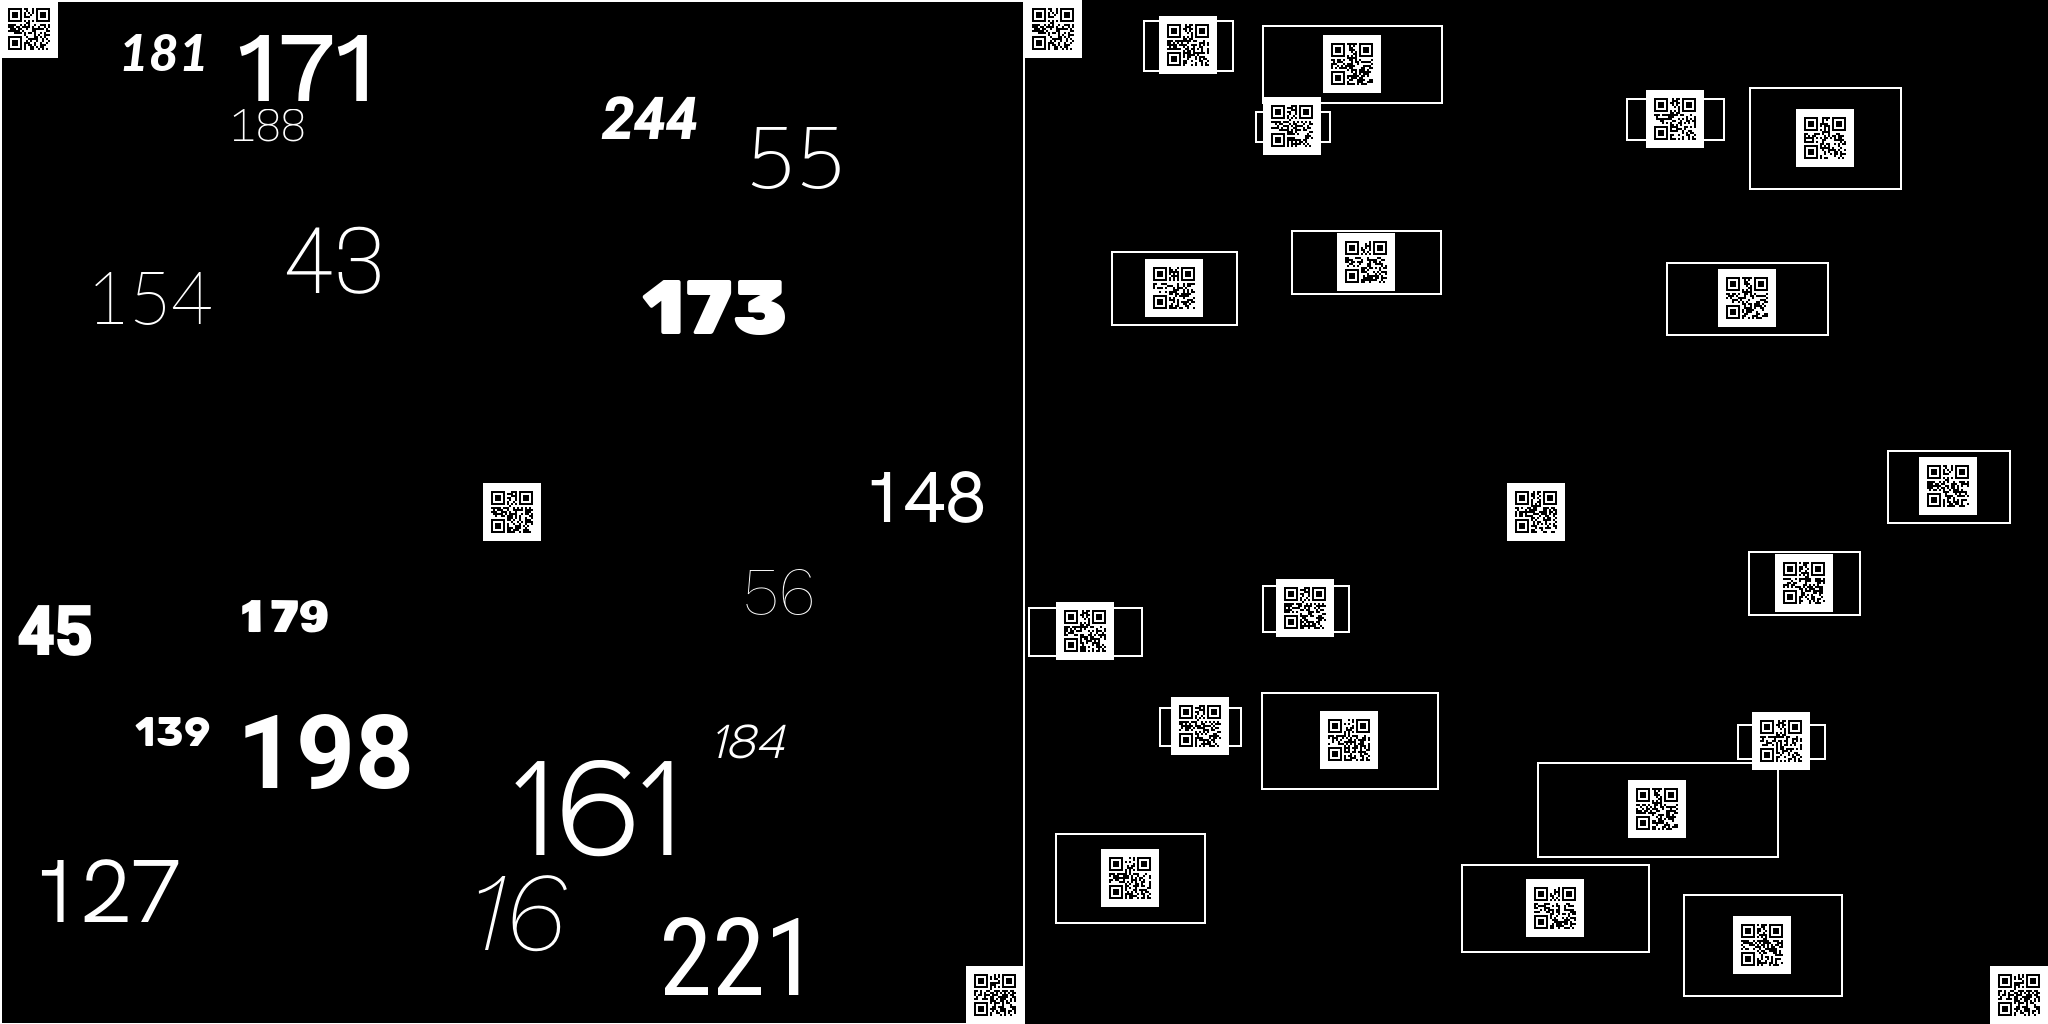

In [29]:
generator = ScreenGenerator(n_frames_per_screen=20)
generator.compose_screen()
numbers_img, labels_img = generator.generate_image_set()
sbs_img = Image.new(mode="RGB",size=(generator.screen_size[0]*2,generator.screen_size[1]))
sbs_img.paste(numbers_img)
sbs_img.paste(labels_img, box=(generator.screen_size[0],0))
draw = ImageDraw.Draw(sbs_img)
draw.rectangle(((0,0), generator.screen_size), outline='white', width=2)
sbs_img

In [70]:
from pyzbar.pyzbar import decode as decodeqr

class LabeledRoi():
    def __init__(self,data, center, size):
        self.data=data
        self.center=center
        self.width=size[0]
        self.height=size[1]
        self.top=center[1]-size[1]/2
        self.bottom=center[1]+size[1]/2
        self.left=center[0]-size[0]/2
        self.right=center[0]+size[0]/2
        
class LabelScreen():
    def __init__(self):
        self.screen_id
        self.labeled_rois = []

class VideoShredder():
    
    def __init__(self):
        self.output_dir = '/data/'
        self.decoded_ids = []
        self.last_valid_label_screen = None

    def decode_label_frame(self, img, screen_id):
        decodedqrs = decodeqr(img)
        for decodedqr in decodedqrs:
            data = decodedqr.data.decode("utf-8")
            rect = decodedqr.rect
            center = ((rect.left+rect.right)/2, (rect.top+rect.bottom)/2)
    
    def read_screen_id(self,img):
        results = decodeqr(img)
        for result in results:
            code = result.data.decode("utf-8")
            print(code[:4])
            if code[:4]=='nums' or code[:4]=='labs':
                print('!!!!!!!!!!!!!')
                a = result.data.decode("utf-8")
                print(a)
                return result.data.decode("utf-8") 
        return None
    
    def next_screen(self, img):
        #read screen id
        screen_id = self.read_screen_id(img)
        if screen_id[:4]=='labs':
            self.decode_label_frame(img, screen_id[:4])
            
        

In [71]:
generator = ScreenGenerator(n_frames_per_screen=20)
generator.compose_screen()
numbers_img, labels_img = generator.generate_image_set()


decoder = VideoShredder()
result = decoder.next_screen(labels_img)
result

n = 1150
BR
238_
18_1
186_
132_
63_9
3_14
124_
130_
labs
!!!!!!!!!!!!!
labs_%Y.B+c


In [15]:
'nums_asdfasdf'[5:]

'asdfasdf'

In [72]:
!git status

fatal: not a git repository (or any of the parent directories): .git


if label image decode_label_image and append labelframe obgect to video shredder